In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

n_splits = 10
seed = 42
np.random.seed(seed)

k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

#### 1 Read and describe data

In [3]:
matches_df = pd.read_csv("../../../data_for_training/arsenal_clustered.csv")
matches_df.columns

Index(['result', 'venue', 'season', 'win_percent_before_team2',
       'win_percent_diff', 'draw_percent_before_team2',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team1', 'average_score_before_match_team2',
       'average_score_before_match_diff', 'Cluster', 'match_type',
       'win_rate_type'],
      dtype='object')

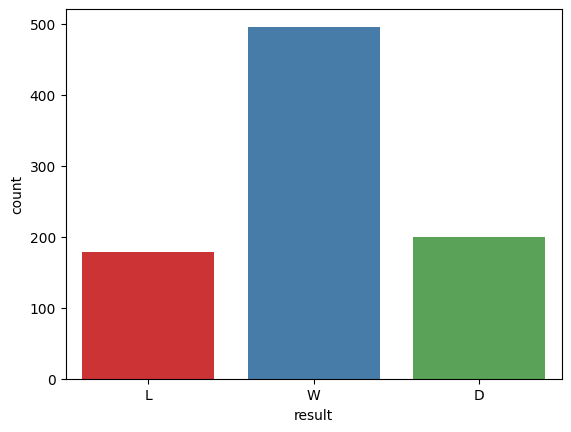

In [4]:
matches_df = matches_df.drop(
    columns=[
        "average_score_before_match_team1",
        "average_score_before_match_diff",
        "draw_percent_before_team2",
    ]
)

sns.countplot(x="result", data=matches_df, palette="Set1");

### Phân chia dữ liệu thành X, y

In [5]:
X = matches_df.drop("result", axis=1)
X.head()

,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type,win_rate_type
0,Away,2000-2001,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,1500.000000,0.000000,0.000000,0,Weak Opponent,Diverse Win Rate
1,Home,2000-2001,1.000000,-1.000000,0.000000,0.0,0.0,0.0,1,1531.250000,-62.500000,3.000000,2,Strong Opponent,High Win Rate
2,Home,2000-2001,0.500000,0.000000,0.500000,0.0,0.0,0.0,0,1513.545664,-0.621645,1.500000,0,Weak Opponent,Diverse Win Rate
3,Away,2000-2001,0.333333,0.333333,0.333333,0.0,0.0,0.0,1,1507.852086,42.639029,1.333333,0,Weak Opponent,Diverse Win Rate
4,Away,2000-2001,0.250000,0.250000,0.500000,0.0,0.0,0.0,0,1456.587085,96.956843,1.000000,0,Weak Opponent,Diverse Win Rate


In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(matches_df["result"])

In [7]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_cols, categorical_cols

(Index(['win_percent_before_team2', 'win_percent_diff',
        'lose_percent_before_team2', 'head2head_win_percent',
        'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
        'ELO_before_match_team2', 'ELO_before_diff',
        'average_score_before_match_team2', 'Cluster'],
       dtype='object'),
 Index(['venue', 'season', 'match_type', 'win_rate_type'], dtype='object'))

#### Encoding cho các đặc trưng

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(use_cat_names=True), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ("match_type", BinaryEncoder(), ["match_type"]),
        ("win_rate_type", BinaryEncoder(), ["win_rate_type"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

transformed_X = preprocessor.fit_transform(X)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor.named_transformers_["season"].get_feature_names_out())
    + list(preprocessor.named_transformers_["match_type"].get_feature_names_out())
    + list(preprocessor.named_transformers_["win_rate_type"].get_feature_names_out())
    + numerical_cols.tolist()
)

transformed_X = pd.DataFrame(transformed_X, columns=columns)
transformed_X.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,match_type_0,match_type_1,win_rate_type_0,...,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.520879,-1.435440,-1.948832,-1.169633,-0.973674,-0.595390,0.026422,-0.826088,-1.794548,-1.119467
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,-3.368248,-1.435440,-1.948832,-1.169633,-0.973674,1.679572,0.155401,-1.022913,2.225725,1.485675
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.520879,0.540040,-1.948832,-1.169633,-0.973674,-0.595390,0.082329,-0.828046,0.215589,-1.119467
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.428244,-0.118454,-1.948832,-1.169633,-0.973674,1.679572,0.058830,-0.691810,-0.007760,-1.119467
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.190964,0.540040,-1.948832,-1.169633,-0.973674,-0.595390,-0.152758,-0.520753,-0.454457,-1.119467


In [9]:
X = transformed_X

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Huấn luyện mô hình với dữ liệu đã xử lý mất cân bằng
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.74      0.78       152
           1       0.73      0.75      0.74       147
           2       0.66      0.71      0.68       148

    accuracy                           0.73       447
   macro avg       0.74      0.73      0.73       447
weighted avg       0.74      0.73      0.73       447



In [11]:
X_test[numerical_cols].mean()

win_percent_before_team2            0.091143
win_percent_diff                   -0.051543
lose_percent_before_team2          -0.081934
head2head_win_percent              -0.050576
head2head_draw_percent              0.022022
head2head_lost_percent              0.054338
is_opponent_big6                    0.119248
ELO_before_match_team2              0.097436
ELO_before_diff                    -0.059937
average_score_before_match_team2    0.105563
Cluster                             0.077692
dtype: float64

Counter({1: 496, 2: 496, 0: 496})


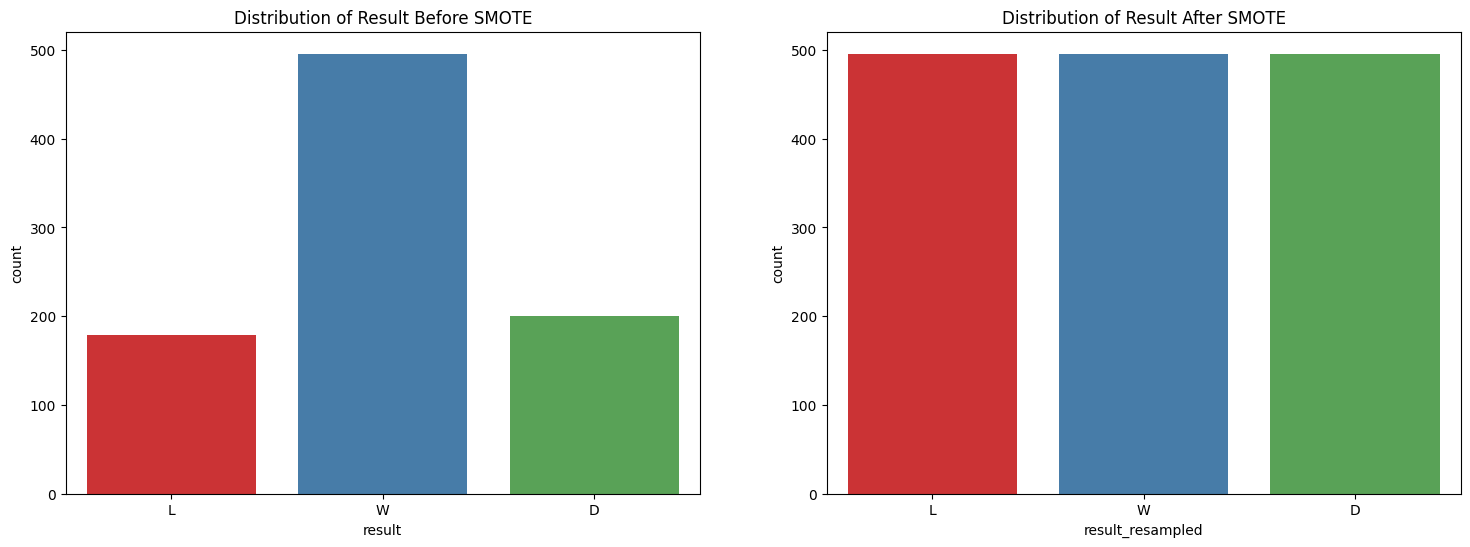

In [11]:
from collections import Counter

# Xem số lượng các giá trị trong y_resampled
counter = Counter(y_resampled)
print(counter)

# Vẽ biểu đồ phân phối của nhãn trước và sau khi áp dụng SMOTE trên cùng một figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Trước khi áp dụng SMOTE
sns.countplot(x="result", data=matches_df, palette="Set1", ax=axes[0])
axes[0].set_title('Distribution of Result Before SMOTE')

# Sau khi áp dụng SMOTE
resampled_df = pd.DataFrame(y_resampled, columns=["result_resampled"])
sns.countplot(x="result_resampled", data=resampled_df, palette="Set1", ax=axes[1])
axes[1].set_title('Distribution of Result After SMOTE')
axes[1].set_xticklabels(['L', 'W', 'D'])

plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Best parameters found: {grid_search.best_params_}')
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       152
           1       0.76      0.74      0.75       147
           2       0.65      0.74      0.69       148

    accuracy                           0.74       447
   macro avg       0.74      0.74      0.74       447
weighted avg       0.75      0.74      0.74       447



In [12]:
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Thử nghiệm với SVM
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print('SVM Classification Report:')
print(classification_report(y_test, y_pred_svc))

# Thử nghiệm với XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       152
           1       0.59      0.69      0.63       147
           2       0.61      0.51      0.56       148

    accuracy                           0.58       447
   macro avg       0.58      0.58      0.58       447
weighted avg       0.58      0.58      0.58       447

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       152
           1       0.75      0.73      0.74       147
           2       0.65      0.70      0.68       148

    accuracy                           0.72       447
   macro avg       0.73      0.72      0.72       447
weighted avg       0.73      0.72      0.72       447



In [13]:
from sklearn.model_selection import cross_val_score

# Đánh giá mô hình với cross-validation
cv_scores = cross_val_score(rf, transformed_X, y, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')


Cross-validation scores: [0.55428571 0.58857143 0.6        0.57714286 0.48      ]
Average cross-validation score: 0.56


#### Note: Cell này dùng để thử nghiệm việc lựa chọn đặc trưng

In [10]:
matches_df = pd.read_csv("../../../data_for_training/arsenal.csv")
matches_df = matches_df.drop(
    columns=[
        "average_score_before_match_team1",
        "average_score_before_match_diff",
        "draw_percent_before_team2",
    ]
)

X = matches_df.drop("result", axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(matches_df["result"])

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(use_cat_names=True), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

X = preprocessor.fit_transform(X)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor.named_transformers_["season"].get_feature_names_out())
    + numerical_cols.tolist()
)

X = pd.DataFrame(X, columns=columns)

### Thử nghiệm các mô hình

In [14]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed, class_weight="balanced")),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
            class_weight="balanced",
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed, class_weight="balanced")),
    (
        "SGDC",
        CalibratedClassifierCV(
            SGDClassifier(random_state=seed, class_weight="balanced")
        ),
    ),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100, random_state=seed, class_weight="balanced"
        ),
    ),
]

cv_results = {}

for name, model in algorithms:
    # Thực hiện cross-validation
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy")
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"Accuracy {name}: {score}")

Accuracy LR: 0.5080854344277163
Accuracy SVC: 0.6129874841284236
Accuracy KNN: 0.6774805006348631
Accuracy DTC: 0.6196716851079268
Accuracy SGDC: 0.4382006167241067
Accuracy NB: 0.4509477598403773
Accuracy RF: 0.7755895156901869


### Chọn bộ siêu tham số

#### SVC

In [16]:
best_params_SVC = {}
models_tuned_SVC = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("SVC", SVC(probability=True)),
]

# Define parameter grid with correct keys
param_grid = {
    "SVC": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Expanded C range
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Added kernel options
        "class_weight": ["balanced"]
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_SVC[name] = randomized_search.best_params_
        models_tuned_SVC[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  SVC
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [17]:
with open('best_params/best_params_SVC.json', 'w') as f:
    json.dump(best_params_SVC, f)

#### RF

In [14]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6],
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4, 6],
        "class_weight": ["balanced"]
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,
            cv=k_fold, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  RF
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [15]:
best_params_RF["RF"]

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20,
 'class_weight': 'balanced'}

#### Các thuật toán khác

In [16]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"],  # Different norms for regularization
        "class_weight": ["balanced", None]  # Added class_weight
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20],  # Added min_samples_leaf
        "class_weight": ["balanced"]
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  LR
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  KNN
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  DTC
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [17]:
with open('best_params/best_params_random_other_balanced.json', 'w') as f:
    json.dump(best_params_random_other, f)

## Thử nghiệm bộ tham số

In [15]:
algorithms_score_df = []

##### SVC

##### Trước resampling

In [19]:
with open('best_params/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

SVC: 0.5542857142857144


##### Sau resampling

In [20]:
with open('best_params/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), class_weight="balanced", random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name  + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

SVC: 0.3897142857142857


##### Random forest

##### Trước resampling

In [11]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(
        model, transformed_X, y, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.5725835945663532


##### Sau resampling

In [16]:
with open('best_params/best_params_RF_balanced.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(
        model, X_resampled, y_resampled, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.7816569925630328


##### Các thuật toán khác

##### Trước resampling

In [54]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.6034285714285714
KNN: 0.5885714285714286
DTC: 0.598857142857143


##### Sau resampling

In [55]:
with open('best_params/best_params_random_other_balanced.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.6034285714285714
KNN: 0.5897142857142856
DTC: 0.4868571428571428


In [56]:
df = pd.DataFrame(algorithms_score_df)
df.sort_values(by="score", ascending=False)


,model,score
4,LRbefore_resampling,0.603429
7,LRafter_resampling,0.603429
2,RFbefore_resampling,0.602286
6,DTCbefore_resampling,0.598857
8,KNNafter_resampling,0.589714
5,KNNbefore_resampling,0.588571
0,SVCbefore_resampling,0.574857
3,RFafter_resampling,0.557714
9,DTCafter_resampling,0.486857
1,SVCafter_resampling,0.473143


#### Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất 

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Random forest

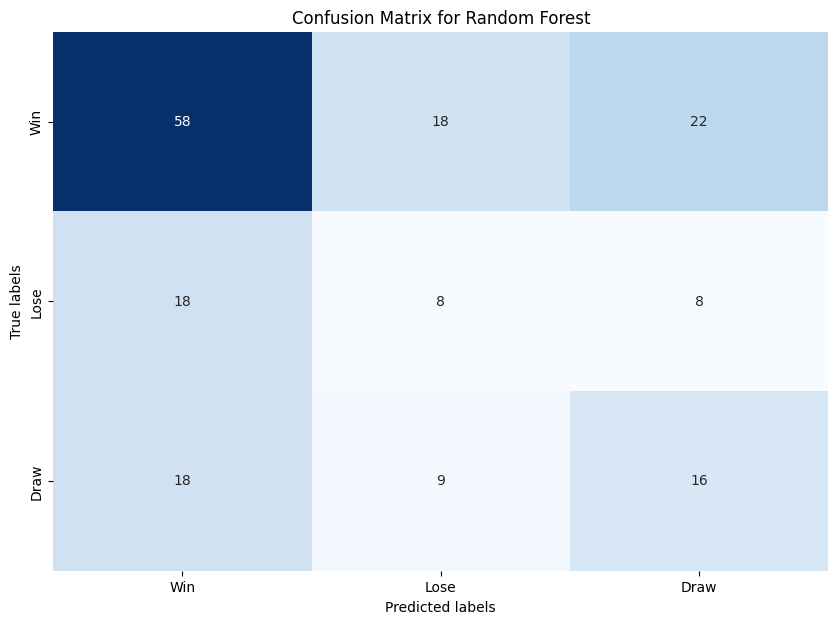

In [17]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), class_weight='balanced', random_state=42)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

##### Linear regression

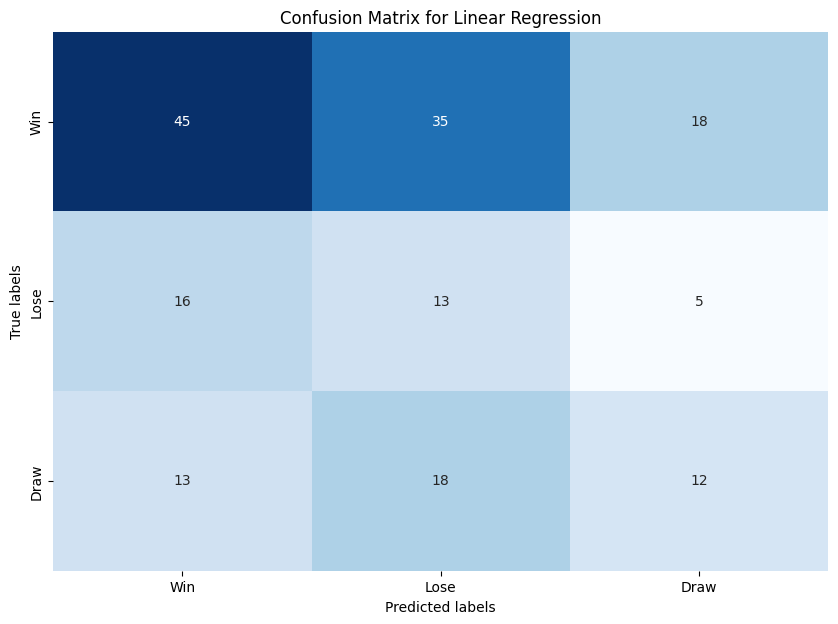

In [18]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params_other = json.load(f)

lr_model = LogisticRegression(**best_params_other.get("LR", {}), class_weight='balanced', random_state=42)

y_pred = lr_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Linear Regression')
plt.show()

## Test Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed, stratify=y_resampled)

In [18]:
from sklearn.metrics import confusion_matrix

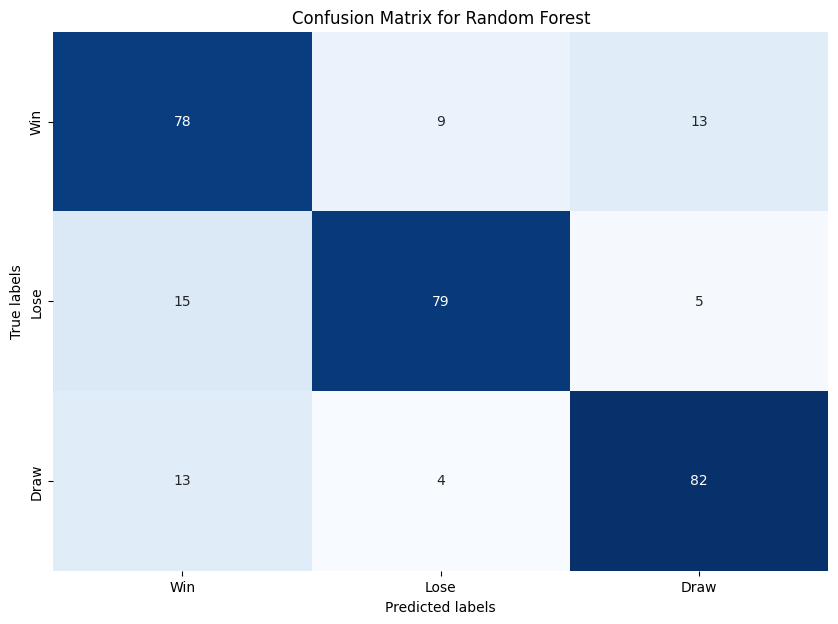

In [19]:
with open('best_params/best_params_RF_balanced.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"].pop("class_weight", None)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

cm_reordered = cm[desired_indices, :][:, desired_indices]
df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [19]:
import pickle
def save_model(model, file_name):
    with open(file_name, "wb") as file:
        pickle.dump(model, file)

In [21]:
# Lưu các encoder
save_model(preprocessor, "final_model_clustered/preprocessor.pkl")

In [22]:
# Lưu model vào file joblib
import joblib

with open('best_params/best_params_RF_balanced.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"]["class_weight"] = "balanced"

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)
rf_model.fit(X, y)

save_model(rf_model, "final_model_clustered/RF.pkl")

### Tạo model cho việc phân cụm

In [30]:
X_resampled

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,match_type_0,match_type_1,win_rate_type_0,...,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,1.0,0.0,...,-0.520879,-1.435440,-1.948832,-1.169633,-0.973674,-0.595390,0.026422,-0.826088,-1.794548,-1.119467
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.0,0.0,1.0,...,-3.368248,-1.435440,-1.948832,-1.169633,-0.973674,1.679572,0.155401,-1.022913,2.225725,1.485675
2,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,1.0,0.0,...,-0.520879,0.540040,-1.948832,-1.169633,-0.973674,-0.595390,0.082329,-0.828046,0.215589,-1.119467
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,1.0,0.0,...,0.428244,-0.118454,-1.948832,-1.169633,-0.973674,1.679572,0.058830,-0.691810,-0.007760,-1.119467
4,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,1.0,0.0,...,0.190964,0.540040,-1.948832,-1.169633,-0.973674,-0.595390,-0.152758,-0.520753,-0.454457,-1.119467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.0,0.0,1.0,...,-1.090353,0.575080,-1.380739,0.696694,1.443862,1.679572,0.658430,-1.291376,-0.064314,1.485675
1484,1.000000,0.000000,0.379867,0.620133,1.000000,1.0,0.000000,1.0,0.0,1.0,...,0.048595,-0.645248,-1.352859,-0.116503,2.166741,1.679572,0.682964,-0.702396,0.682011,1.485675
1485,0.277381,0.722619,0.000000,0.722619,0.722619,1.0,1.000000,0.0,1.0,0.0,...,-0.109366,-0.426064,-0.469491,-0.139190,1.005883,-0.595390,0.614161,0.476451,0.811291,-1.119467
1486,0.188121,0.811879,1.000000,0.000000,0.000000,1.0,0.811879,1.0,0.0,1.0,...,-0.520879,-1.435440,-1.442575,0.936627,1.302316,1.679572,0.216126,-0.799637,-1.340769,1.485675


In [31]:
from sklearn.cluster import KMeans
import pickle

# Giả sử bạn đã có tập huấn luyện X_train
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_resampled)

# Lưu mô hình phân cụm
with open("final_model_clustered/kmeans_model.pkl", "wb") as file:
    pickle.dump(kmeans, file)


In [26]:
def assign_cluster_label(cluster):
    if cluster == 0:
        return 'Weak Opponent'
    elif cluster == 1:
        return 'Average Opponent'
    elif cluster == 2:
        return 'Strong Opponent'
    else:
        return 'Unknown'

def assign_win_label(cluster):
    if cluster == 0:
        return 'Diverse Win Rate'
    elif cluster == 1:
        return 'Low Win Rate'
    elif cluster == 2:
        return 'High Win Rate'
    else:
        return 'Unknown'


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ClusteringFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, kmeans_model):
        self.kmeans_model = kmeans_model

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        clusters = self.kmeans_model.predict(X)
        X['Cluster'] = clusters
        X['match_type'] = X['Cluster'].apply(assign_cluster_label)
        X['win_rate_type'] = X['Cluster'].apply(assign_win_label)
        return X
# Tải mô hình phân cụm đã huấn luyện
with open("final_model_clustered/kmeans_model.pkl", "rb") as file:
    kmeans_model = pickle.load(file)

# Tạo lớp tùy chỉnh để thêm các đặc trưng phân cụm
clustering_adder = ClusteringFeatureAdder(kmeans_model=kmeans_model)